In [474]:
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
import numpy as np
from itertools import product
import pandas as pd
import os
import rasterio.warp as rasteriowarp
import time

In [2]:
SATELLITE_DATA_PATH = '/storage/data/eumetsat/native/reprojected2/'
PV_DATA_FILENAME = '~/data/pvoutput.org/UK_PV_timeseries_batch.nc'
PV_METADATA_FILENAME = '~/data/pvoutput.org/UK_PV_metadata.csv'

DST_CRS = {
    'ellps': 'WGS84',
    'proj': 'tmerc',  # Transverse Mercator
    'units': 'm'  # meters
}

# Geospatial boundary in Transverse Mercator (meters)
SOUTH = 5513500
NORTH = 6613500
WEST =  -889500
EAST =   410500

## Load and convert PV metadata

In [3]:
pv_metadata = pd.read_csv(PV_METADATA_FILENAME, index_col='system_id')
pv_metadata.dropna(subset=['longitude', 'latitude'], how='any', inplace=True)

In [4]:
# Convert lat lons to Transverse Mercator
pv_metadata['x'], pv_metadata['y'] = rasteriowarp.transform(
    src_crs={'init': 'EPSG:4326'},
    dst_crs=DST_CRS,
    xs=pv_metadata['longitude'].values,
    ys=pv_metadata['latitude'].values)

# Filter 3 PV systems which apparently aren't in the UK!
pv_metadata = pv_metadata[
    (pv_metadata.x >= WEST) &
    (pv_metadata.x <= EAST) &
    (pv_metadata.y <= NORTH) &
    (pv_metadata.y >= SOUTH)]

len(pv_metadata)

2548

## Load and normalise PV power data

In [5]:
%%time
pv_power = xr.load_dataset(PV_DATA_FILENAME)

CPU times: user 14.7 s, sys: 2.29 s, total: 17 s
Wall time: 17.3 s


In [657]:
pv_power_selected = pv_power.loc[dict(datetime=slice('2019-01-01', '2019-07-01'))]

In [658]:
pv_power_df = pv_power_selected.to_dataframe().dropna(axis='columns', how='all')
pv_power_df = pv_power_df.clip(lower=0, upper=5E7)
pv_power_df.columns = [np.int64(col) for col in pv_power_df.columns]

In [659]:
# A bit of hand-crafted cleaning
pv_power_df[30248][:'2019-01-03'] = np.NaN

In [660]:
# Normalise
pv_power_df -= pv_power_df.min()
pv_power_df /= pv_power_df.max()

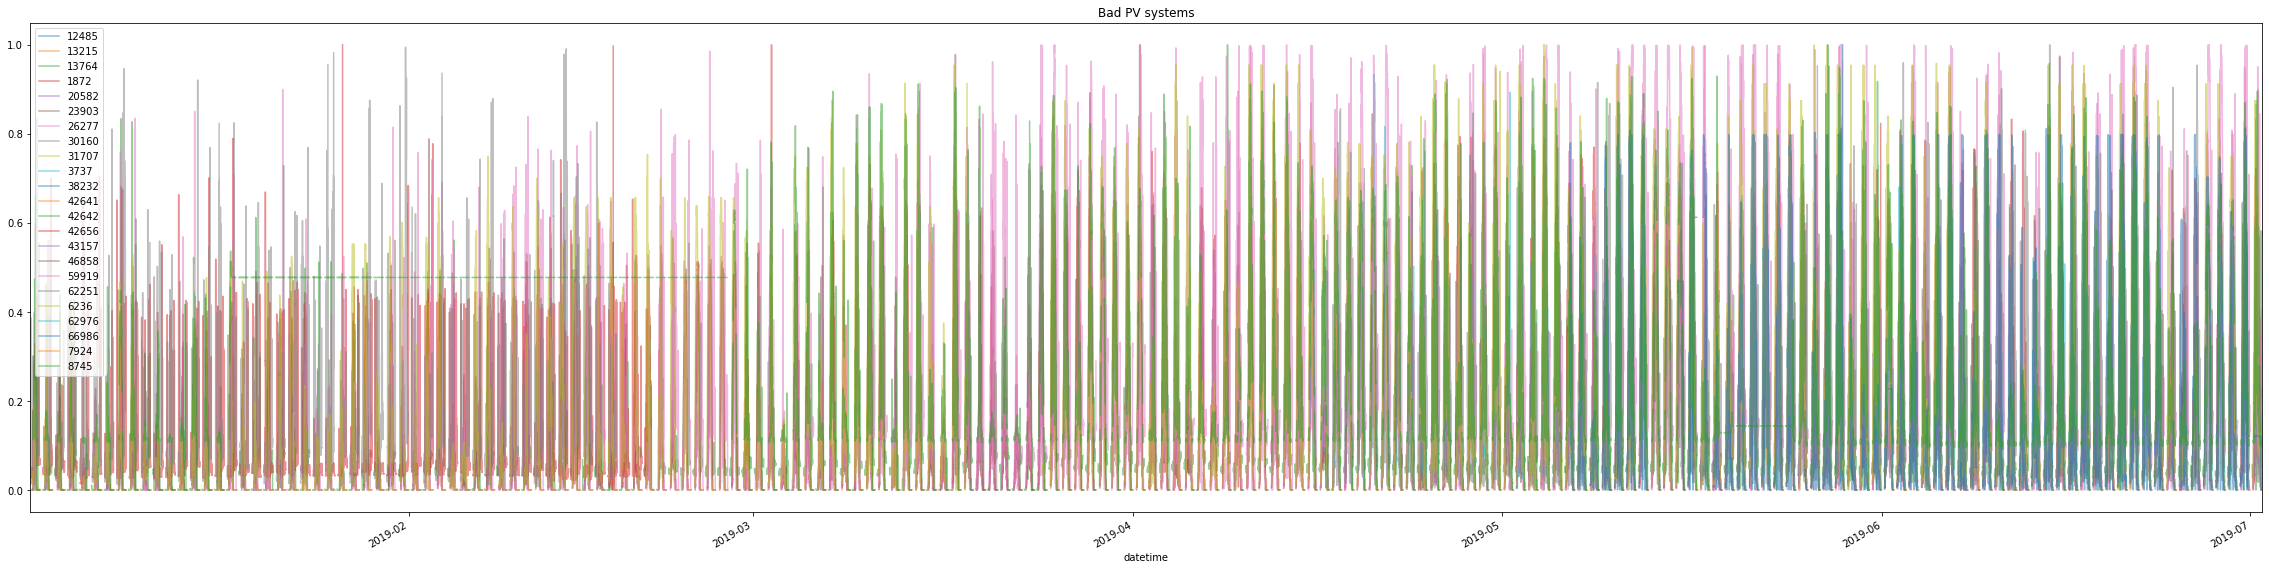

In [661]:
# Drop systems which are producing over night
NIGHT_YIELD_THRESHOLD = 0.4
night_hours = list(range(21, 24)) + list(range(0, 4))
bad_systems = np.where(
    (pv_power_df[pv_power_df.index.hour.isin(night_hours)] > NIGHT_YIELD_THRESHOLD).sum()
)[0]
bad_systems = pv_power_df.columns[bad_systems]
ax = pv_power_df[bad_systems].plot(figsize=(40, 10), alpha=0.5)
ax.set_title('Bad PV systems');

In [662]:
pv_power_df.drop(bad_systems, axis='columns', inplace=True)

In [663]:
# Interpolate
pv_power_df = pv_power_df.interpolate(limit=3)

In [664]:
len(pv_power_df.columns)

861

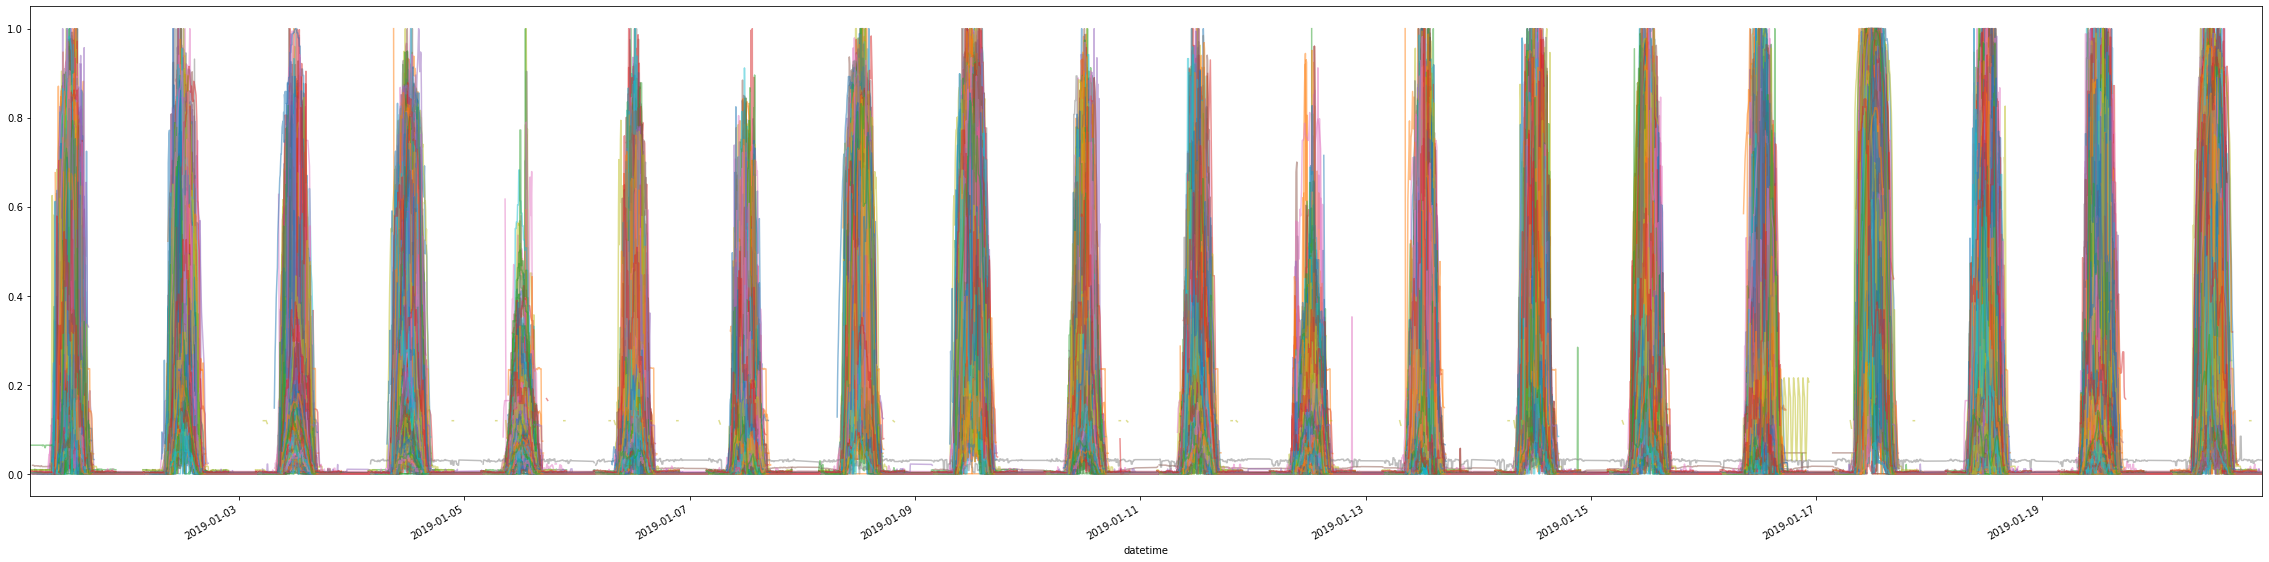

In [14]:
pv_power_df.plot(figsize=(40, 10), alpha=0.5, legend=False);

In [665]:
# Sort the metadata in the same order as the PV power data
pv_metadata = pv_metadata.reindex(pv_power_df.columns, axis='index')

## Load satellite data

In [654]:
%%time
#DATES = pd.date_range("2019-01-01", "2019-06-30", freq="D")
#HOURS = range(8, 17)
#satellite_data_filenames = [
#    os.path.join(SATELLITE_DATA_PATH, '{}T{:02d}.nc'.format(day.strftime('%Y-%m-%d'), hour))
#    for day, hour in list(product(DATES, HOURS))]

CPU times: user 12.4 ms, sys: 19 µs, total: 12.4 ms
Wall time: 16.2 ms


In [656]:
%%time
satellite_data_filenames = os.path.join(SATELLITE_DATA_PATH, '*.nc')
dataset = xr.open_mfdataset(paths=satellite_data_filenames, concat_dim='time')
da = dataset['HRV']

/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets a

CPU times: user 26.2 s, sys: 1.18 s, total: 27.4 s
Wall time: 1min 21s


In [666]:
def get_rectangle_of_satellite_data(time, centre_x, centre_y, width=128000, height=128000):
    half_width = width / 2
    half_height = height / 2
    
    north = centre_y + half_height
    south = centre_y - half_height
    east = centre_x + half_width
    west = centre_x - half_width
    
    data = da.loc[dict(
        time=time,
        x=slice(west, east), 
        y=slice(north, south))]
    
    return data

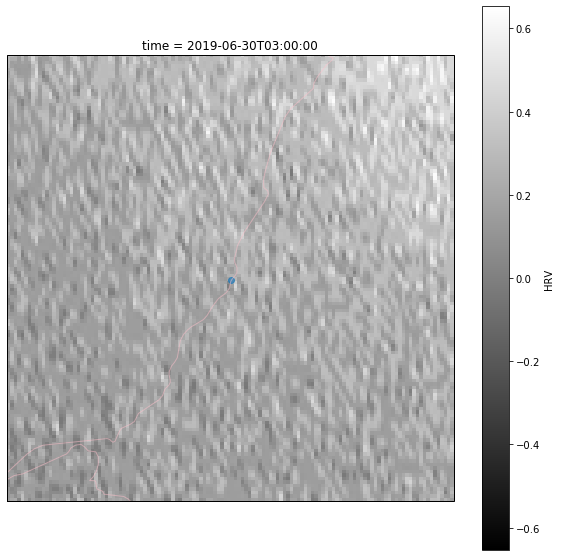

In [677]:
# Test get rectangle
dt = pd.Timestamp('2019-06-30 03:00')
pv_system_id = pv_metadata.index[0]
x, y = pv_metadata.loc[pv_system_id][['x', 'y']]

fig = plt.figure(figsize=(10, 10))
crs = ccrs.TransverseMercator()
ax = plt.axes(projection=crs)
ax.coastlines(resolution='10m', alpha=0.5, color='pink')

sat_data = get_rectangle_of_satellite_data(time=dt, centre_x=x, centre_y=y)
img = sat_data.plot.imshow(ax=ax, cmap='gray', origin='upper', add_colorbar=True)
path_collection = ax.scatter(x=x, y=y, alpha=0.7)

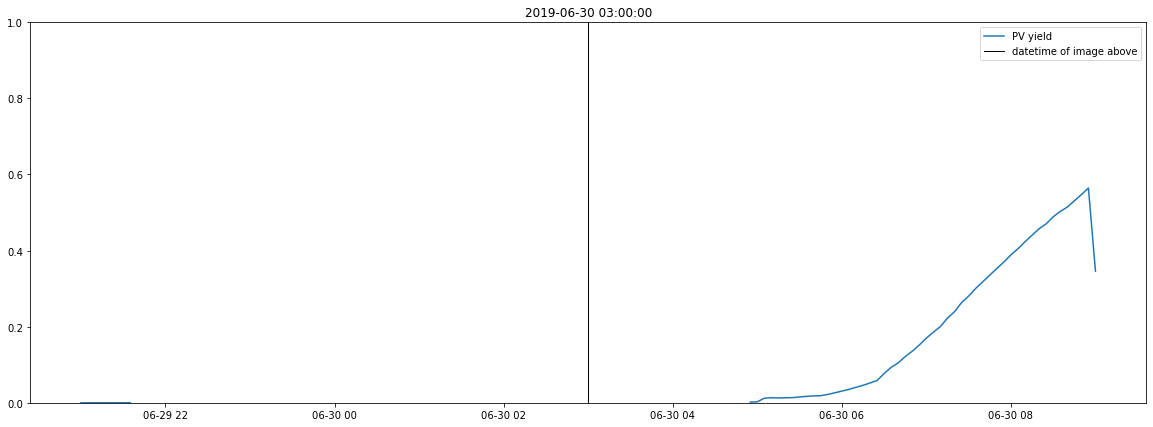

In [678]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(
    pv_power_df[pv_system_id][dt - timedelta(hours=6):dt + timedelta(hours=6)], 
    label='PV yield')
ax.plot((dt, dt), (0, 1), linewidth=1, color='black', label='datetime of image above')
ax.legend()
ax.set_title(dt)
ax.set_ylim((0, 1));

In [227]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [437]:
torch.cuda.get_device_name(0)

'GeForce RTX 2080 Ti'

In [672]:
class PVDataset(Dataset):
    def __init__(self, train=False):
        self.pv_data = pv_power_df[pv_system_id].dropna()
        
        train_test_split = int(len(self.pv_data) / 5)
        if train:
            self.pv_data = self.pv_data.iloc[train_test_split:]
        else:
            self.pv_data = self.pv_data.iloc[:train_test_split]
        
        # Load satellite data into RAM
        start_date, end_date = self.pv_data.index[[0, -1]]
        
        self.sat_data = get_rectangle_of_satellite_data(
            time=slice(start_date, end_date), 
            centre_x=x, 
            centre_y=y)
        
        # normalise sat data
        self.sat_data -= self.sat_data.mean()
        self.sat_data /= self.sat_data.std()
        self.sat_data = self.sat_data.load()
        
        self.datetime_index = self.pv_data.index.intersection(self.sat_data.time.values)

    def __len__(self):
        return len(self.datetime_index)
    
    def __getitem__(self, idx):
        dt = self.datetime_index[idx]
        pv_data = self.pv_data.loc[dt]
        sat_data = self.sat_data.sel(time=dt).values
        sat_data = sat_data[np.newaxis]
        pv_data = np.array([pv_data])
        
        assert not any(np.isnan(pv_data).flatten())
        assert not any(np.isnan(sat_data).flatten())
        
        return torch.cuda.FloatTensor(sat_data), torch.cuda.FloatTensor(pv_data)

In [673]:
%%time
pv_dataset_test = PVDataset(train=False)

KeyboardInterrupt: 

In [674]:
pv_dataset_test = pv_dataset_train
del pv_dataset_train

NameError: name 'pv_dataset_train' is not defined

In [ ]:
%%time
pv_dataset_train = PVDataset(train=True)

In [584]:
%%time
sat_data, pv_data = pv_dataset[1500]
print(sat_data.shape)
print(pv_data.shape)

torch.Size([1, 128, 128])
torch.Size([1])
CPU times: user 7.13 ms, sys: 3.95 ms, total: 11.1 ms
Wall time: 9.84 ms


In [592]:
dataloader = DataLoader(pv_dataset, batch_size=32, shuffle=True, drop_last=True)

In [593]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # x is now <batch_size>, 6, 62, 62.  
        # 62 is 124 / 2.  124 is the 128-dim input - 4
        x = self.pool(F.relu(self.conv2(x)))
        # x is now <batch_size>, 16, 29, 29
        x = x.view(-1, 16 * 29 * 29)
        # x is now <batch_size>, 16 x 29 x 29
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net().cuda()

In [599]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
loss_func = nn.MSELoss()

In [600]:
STATS_PERIOD = 5

losses = []
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0

    t0 = time.time()
    for i_batch, (inputs, target) in enumerate(dataloader):
        print('\r', i_batch, end='', flush=True)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_func(outputs, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i_batch % STATS_PERIOD == STATS_PERIOD - 1:    # print every 2000 mini-batches
            t1 = time.time()
            mean_loss = running_loss / STATS_PERIOD
            losses.append(mean_loss)
            print('\n[%d, %5d] loss: %.3f; time= %.2f s' %
                  (epoch + 1, i_batch + 1, mean_loss, t1 - t0))
            running_loss = 0.0
            t0 = time.time()

print('Finished Training')

 4
[1,     5] loss: 0.018; time= 0.19 s
 9
[1,    10] loss: 0.017; time= 0.18 s
 14
[1,    15] loss: 0.011; time= 0.17 s
 19
[1,    20] loss: 0.015; time= 0.17 s
 24
[1,    25] loss: 0.010; time= 0.18 s
 29
[1,    30] loss: 0.017; time= 0.18 s
 34
[1,    35] loss: 0.013; time= 0.17 s
 39
[1,    40] loss: 0.011; time= 0.18 s
 44
[1,    45] loss: 0.016; time= 0.22 s
 49
[1,    50] loss: 0.015; time= 0.19 s
 41
[2,     5] loss: 0.011; time= 0.17 s
 9
[2,    10] loss: 0.017; time= 0.16 s
 14
[2,    15] loss: 0.013; time= 0.18 s
 19
[2,    20] loss: 0.010; time= 0.17 s
 24
[2,    25] loss: 0.011; time= 0.17 s
 29
[2,    30] loss: 0.011; time= 0.16 s
 34
[2,    35] loss: 0.013; time= 0.16 s
 39
[2,    40] loss: 0.013; time= 0.17 s
 44
[2,    45] loss: 0.011; time= 0.17 s
 49
[2,    50] loss: 0.012; time= 0.17 s
 51Finished Training


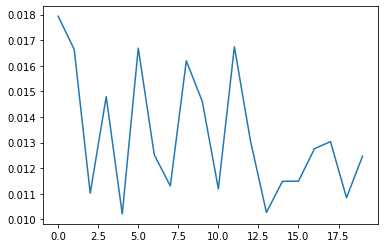

In [601]:
plt.plot(losses);

In [604]:
for inputs, target in dataloader:
    break

In [606]:
output = net(inputs)

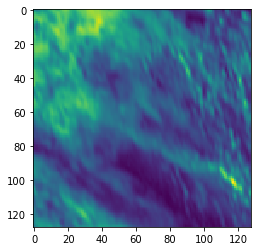

In [649]:
i = 8
plt.imshow(inputs[i, 0].cpu(), origin='upper')

In [650]:
output[i, 0].detach().cpu()

tensor(0.5081)

In [651]:
target[i, 0].detach().cpu()

tensor(0.4583)

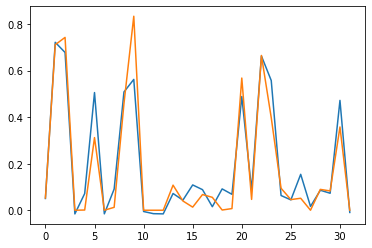

In [653]:
fig, ax = plt.subplots()

ax.plot(output[:, 0].detach().cpu(), label='net output')
ax.plot(target[:, 0].detach().cpu(), label='target')